### Load data from snowflake

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Postgres and Snowflake") \
    .config("spark.jars.packages",
            "net.snowflake:spark-snowflake_2.12:2.11.0-spark_3.3,"
            "net.snowflake:snowflake-jdbc:3.13.22") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.memoryOverhead", "2g") \
    .getOrCreate()

:: loading settings :: url = jar:file:/home/hadoop/spark-3.5.5-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/hadoop/.ivy2/cache
The jars for the packages stored in: /home/hadoop/.ivy2/jars
net.snowflake#spark-snowflake_2.12 added as a dependency
net.snowflake#snowflake-jdbc added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c8680c0d-1018-4ec0-a019-2c73c6939759;1.0
	confs: [default]
	found net.snowflake#spark-snowflake_2.12;2.11.0-spark_3.3 in central
	found net.snowflake#snowflake-ingest-sdk;0.10.8 in central
	found net.snowflake#snowflake-jdbc;3.13.22 in central
:: resolution report :: resolve 464ms :: artifacts dl 22ms
	:: modules in use:
	net.snowflake#snowflake-ingest-sdk;0.10.8 from central in [default]
	net.snowflake#snowflake-jdbc;3.13.22 from central in [default]
	net.snowflake#spark-snowflake_2.12;2.11.0-spark_3.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|

In [2]:
from dotenv import load_dotenv
import os

dotenv_path = os.path.abspath("../../spark/.env")
load_dotenv(dotenv_path=dotenv_path)
#snowflake conector config
sfOptions = {
    "sfURL": os.getenv("SF_URL"),
    "sfUser": os.getenv("SF_USER"),
    "sfPassword": os.getenv("SF_PASSWORD"),
    "sfDatabase": os.getenv("SF_DATABASE"),
    "sfSchema": os.getenv("SF_SCHEMA"),
    "sfWarehouse": os.getenv("SF_WAREHOUSE"),
    "sfRole": os.getenv("SF_ROLE"),
    "insecureMode": "true"
}

In [11]:
df = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.MONTHLY_REVENUE_PROFIT") \
    .load()

df.show()

25/06/04 11:33:50 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+----------+--------------------+--------------------+
|     MONTH|       TOTAL_REVENUE|        TOTAL_PROFIT|
+----------+--------------------+--------------------+
|2010-08-31|       4.730385618E7|   8974623.309999999|
|2010-09-30|       3.488176629E7|          6510791.89|
|2010-10-31|       3.213256536E7|   5843810.079999999|
|2010-11-30|       2.746249758E7|   5002567.209999999|
|2010-12-31|       3.230382141E7|          5897933.77|
|2011-01-31|2.5395054299999997E7|   4532500.869999999|
|2011-02-28|       3.256495389E7|          5946416.81|
|2011-03-31|        4.30992324E7|           7923602.5|
|2011-04-30|6.0289240410000004E7|       1.123346011E7|
|2011-05-31|5.6407506120000005E7|1.0365459649999999E7|
|2011-06-30|       5.767097049E7|       1.058524743E7|
|2011-07-31|5.4517927589999996E7|          9745486.74|
|2011-08-31|       5.687060589E7|       1.005963995E7|
|2011-09-30|4.0379172120000005E7|          7224032.92|
|2011-10-31|       3.277267875E7|          5921669.93|
|2011-11-3

In [12]:
df.printSchema()

root
 |-- MONTH: date (nullable = true)
 |-- TOTAL_REVENUE: double (nullable = true)
 |-- TOTAL_PROFIT: double (nullable = true)



After reading data from Snowflake, we use two models to predict monthly revenue: XGBoost and ARIMA.

In [9]:
import pandas as pd

In [14]:
df = df.toPandas()
df.head()

,MONTH,TOTAL_REVENUE,TOTAL_PROFIT
0,2010-08-31,47303856.18,8974623.31
1,2010-09-30,34881766.29,6510791.89
2,2010-10-31,32132565.36,5843810.08
3,2010-11-30,27462497.58,5002567.21
4,2010-12-31,32303821.41,5897933.77


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MONTH          143 non-null    object 
 1   TOTAL_REVENUE  143 non-null    float64
 2   TOTAL_PROFIT   143 non-null    float64
dtypes: float64(2), object(1)
memory usage: 3.5+ KB


In [16]:
df.set_index('MONTH', inplace=True)
df.index = pd.to_datetime(df.index)

### XGBoost Model

In [29]:
df_train = df[(df.index < '2021-01-01')]
df_test = df[df.index >= '2021-01-01']

In [7]:
from statsmodels.tsa.seasonal import MSTL

from feature_engine.timeseries.forecasting import LagFeatures
from feature_engine.imputation import DropMissingData
from sklearn.pipeline import Pipeline

In [8]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

In [20]:
def linear(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return  model.predict(X_test)

In [21]:
def xgboots(X_train, y_train, X_test):
    xgb = XGBRegressor()

    param_grid = {
        'n_estimators': [30, 40, 50, 100, 200, 300],
        'learning_rate': [0.03, 0.05, 0.1, 0.01],
        'max_depth': [3, 4, 5, 7],
        'subsample': [0.7, 0.9, 0.8],
        'colsample_bytree': [0.5, 0.7]
    }

    grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    print("Best parameters found: ", grid_search.best_params_)
    print("Best score found: ", grid_search.best_score_)
    best_model = grid_search.best_estimator_
    
    y_pred = best_model.predict(X_test)
    return y_pred

In [22]:
def feature_engine(columns):
    lag_transformer = LagFeatures(variables=[columns], periods=[1, 6, 12])
    imputer = DropMissingData()
    pipe = Pipeline(
        [
            ("lag", lag_transformer),
            ("imputer", imputer),
        ]
    )
    return pipe

def decomposing(data):
    mstl = MSTL(data.interpolate(method="linear"), periods=(6, 12))
    res = mstl.fit()
    return res

def prepare_features(data, component_name, lag_periods):
    pipe = feature_engine(component_name)
    data_transformed = pipe.fit_transform(data)
    
    feature_cols = [f"{component_name}_lag_{period}" for period in lag_periods]
    X = data_transformed[feature_cols]
    y = data_transformed[component_name]
    
    return X, y, pipe

def prepare_test_features(train_component, test_component, component_name, lag_periods, pipe):
    # Lấy 12 tháng cuối của train và nối với test
    train_tail = train_component.iloc[-12:]
    extended_test = pd.concat([train_tail, test_component])


    test_transformed = pipe.transform(extended_test)
    

    feature_cols = [f"{component_name}_lag_{period}" for period in lag_periods]
    X_test = test_transformed[feature_cols]
    
    return X_test

In [23]:
def decompose_and_forecast(train, test, col_name):
    # Decompose tập train
    train_res = decomposing(train[col_name])
    train_components = {
        'trend': pd.DataFrame(train_res.trend),
        'seasonal_6': pd.DataFrame(train_res.seasonal["seasonal_6"]),
        'seasonal_12': pd.DataFrame(train_res.seasonal["seasonal_12"]),
        'resid': pd.DataFrame(train_res.resid)
    }

    # Thêm 12 tháng cuối của train vào test để decompose
    train_tail = train.iloc[-12:]
    extended_test = pd.concat([train_tail, test])

    # Decompose tập test mở rộng
    extended_test_res = decomposing(extended_test[col_name])

    # Chỉ lấy phần test thực sự (bỏ 12 tháng train)
    test_components = {
        'trend': pd.DataFrame(extended_test_res.trend).iloc[12:],
        'seasonal_6': pd.DataFrame(extended_test_res.seasonal["seasonal_6"]).iloc[12:],
        'seasonal_12': pd.DataFrame(extended_test_res.seasonal["seasonal_12"]).iloc[12:],
        'resid': pd.DataFrame(extended_test_res.resid).iloc[12:]
    }

    component_configs = {
        'trend': {'lag_periods': [1, 6, 12], 'model': 'linear'},
        'seasonal_6': {'lag_periods': [1, 6, 12], 'model': 'xgboost'},
        'seasonal_12': {'lag_periods': [6, 12], 'model': 'xgboost'},
        'resid': {'lag_periods': [1, 6, 12], 'model': 'linear'}
    }

    # Dự báo cho mỗi thành phần
    final_predictions = np.zeros(len(test))

    for component_name, config in component_configs.items():
        # Chuẩn bị dữ liệu train
        train_data = train_components[component_name]
        X_train, y_train, pipe = prepare_features(train_data, component_name, config['lag_periods'])
        
        # Chuẩn bị dữ liệu test
        test_data = test_components[component_name]
        X_test = prepare_test_features(train_data, test_data, component_name, config['lag_periods'], pipe)
        print(f"Component: {component_name}, X_test.shape: {X_test.shape}")
        
        # Huấn luyện và dự báo
        if config['model'] == 'linear':
            component_predictions = linear(X_train, y_train, X_test)
        else:
            component_predictions = xgboots(X_train, y_train, X_test)
        
        # Thêm dự báo vào kết quả cuối cùng
        final_predictions += component_predictions

    return final_predictions


In [24]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error, root_mean_squared_error
def evaluate_model(y_preds, y_true):
    return {
        'R2 score': r2_score(y_true=y_true, y_pred=y_preds),
        'MAPE': mean_absolute_percentage_error(y_true=y_true, y_pred=y_preds),
        'RMSE': root_mean_squared_error(y_true=y_true, y_pred=y_preds)
    }

### Profit Prediction

In [30]:
df_train

,TOTAL_REVENUE,TOTAL_PROFIT
MONTH,,
2010-08-31,47303856.18,8974623.31
2010-09-30,34881766.29,6510791.89
2010-10-31,32132565.36,5843810.08
2010-11-30,27462497.58,5002567.21
2010-12-31,32303821.41,5897933.77
...,...,...
2020-08-31,35784953.82,5350265.84
2020-09-30,26821540.62,3927402.20
2020-10-31,22870218.42,3536363.23


In [31]:
profit_test_pred = decompose_and_forecast(df_train, df_test, 'TOTAL_PROFIT')

Component: trend, X_test.shape: (18, 3)
Component: seasonal_6, X_test.shape: (18, 3)
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.1s[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.7; total time=   0.0s[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.8; total time=   0.1s


[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.5, learning_rate=0

In [32]:
print("Kết quả dự đoán theo lợi nhuận: ",evaluate_model(df_test["TOTAL_PROFIT"], profit_test_pred))   

Kết quả dự đoán theo lợi nhuận:  {'R2 score': 0.9648468998499979, 'MAPE': 0.053301242866072296, 'RMSE': 290038.79821336287}


### Revenue Prediction

In [33]:
predict_revenue = decompose_and_forecast(df_train, df_test, 'TOTAL_REVENUE')

Component: trend, X_test.shape: (18, 3)
Component: seasonal_6, X_test.shape: (18, 3)
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.0s
[CV] END colsample_bytree=0.5, learning_rate=0

In [35]:
print("Kết quả dự đoán theo doanh thu: ",evaluate_model(df_test["TOTAL_REVENUE"], predict_revenue))

Kết quả dự đoán theo doanh thu:  {'R2 score': 0.9334497130376574, 'MAPE': 0.06052628772827267, 'RMSE': 2534080.8323498713}


### Manual Prediction

In [3]:
df_annual = spark.read \
    .format("snowflake") \
    .options(**sfOptions) \
    .option("dbtable", "SALES_ANALYTICS.PUBLIC.ANNUAL_REVENUE_PROFIT") \
    .load()

df_annual.show()

25/06/04 14:52:31 WARN SnowflakeConnectorUtils$: Query pushdown is not supported because you are using Spark 3.5.5 with a connector designed to support Spark 3.3. Either use the version of Spark supported by the connector or install a version of the connector that supports your version of Spark.


+----------+--------------------+--------------------+
|      YEAR|       TOTAL_REVENUE|        TOTAL_PROFIT|
+----------+--------------------+--------------------+
|2017-01-01|        3.70404972E8|       6.750144601E7|
|2018-01-01|      3.2727089745E8|5.9625960050000004E7|
|2019-01-01|3.4534791081000006E8| 5.775361218000001E7|
|2020-01-01|      3.6589619304E8|       5.575461556E7|
|2021-01-01|      3.8302924401E8| 5.508105359000001E7|
|2022-01-01|2.1367982726999998E8|2.5899571520000003E7|
|2010-01-01|      1.7408450682E8|3.2229726259999998E7|
|2011-01-01|5.1988288904999995E8| 9.481850978999999E7|
|2012-01-01|       5.508013581E8|       9.972657265E7|
|2013-01-01|       5.942221047E8|      1.0861613995E8|
|2014-01-01|      6.3559050345E8|1.0958675599999999E8|
|2015-01-01|      6.1245301887E8|       1.088007546E8|
|2016-01-01|        5.64098472E8|1.0476064449000001E8|
+----------+--------------------+--------------------+



In [4]:
df_annual = df_annual.toPandas()
df_annual.set_index('YEAR', inplace=True)

In [10]:
df_annual.index = pd.to_datetime(df_annual.index)

In [11]:
df_annual['lag_1'] = df_annual['TOTAL_PROFIT'].shift(1)
train = df_annual[(df_annual.index < "2021-01-01") & (df_annual.index >= '2017-01-01')]
test = df_annual[df_annual.index >= "2021-01-01"]

In [12]:
X_train = train["lag_1"]
y_train = train["TOTAL_PROFIT"]

X_test = test["lag_1"]
y_test = test["TOTAL_PROFIT"]

In [13]:
# Initialize the XGBRegressor
xgb = XGBRegressor()

# Define the parameter grid
param_grid = {
    'n_estimators': [30, 40, 50],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Test MSE: ", mse)
print("Test RMSE: ", rmse)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.7; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, n_estimators=40, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, n_estimators=30, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.03, max_depth=3, n_estimators=40,

In [14]:
import matplotlib.pyplot as plt

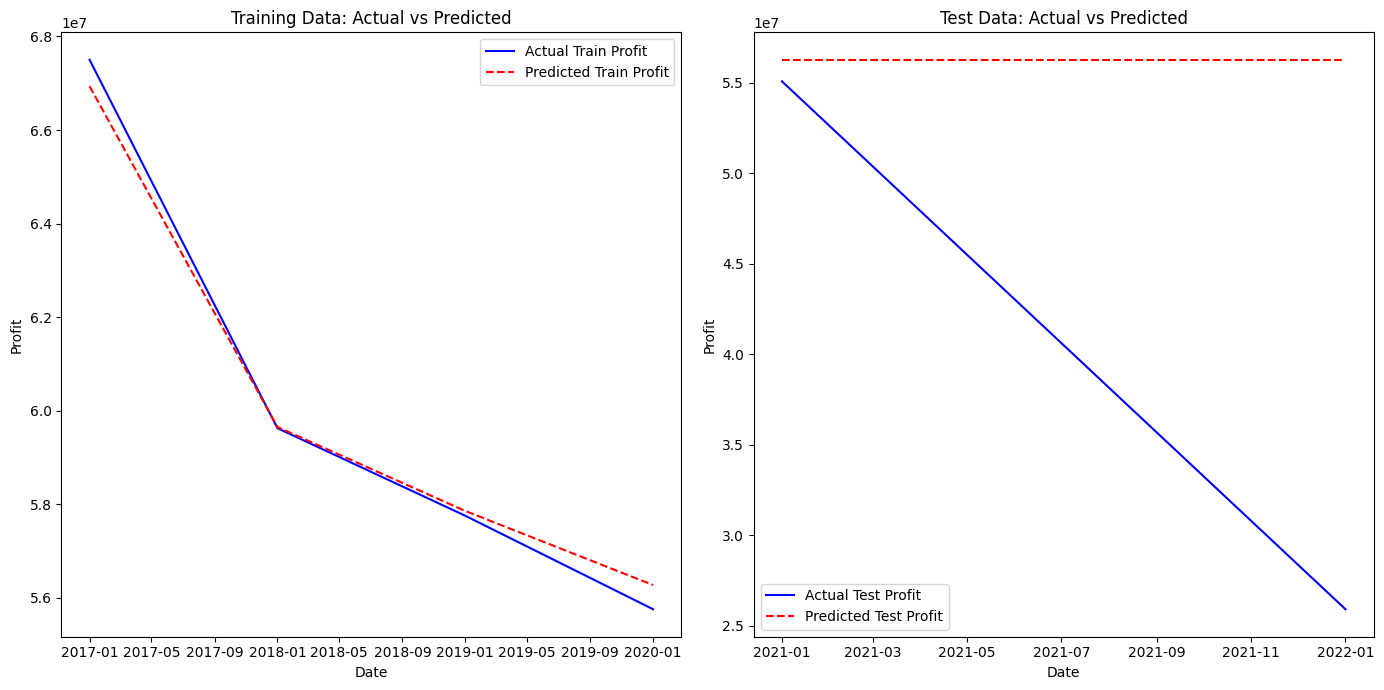

In [15]:
# Predict on the training set to evaluate performance
y_train_pred = best_model.predict(X_train)

# Plotting the training results
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)  # Subplot 1
plt.plot(y_train.index, y_train, label='Actual Train Profit', color='blue')
plt.plot(y_train.index, y_train_pred, label='Predicted Train Profit', color='red', linestyle='--')
plt.title('Training Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()

# Plotting the testing results
plt.subplot(1, 2, 2)  # Subplot 2
plt.plot(y_test.index, y_test, label='Actual Test Profit', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted Test Profit', color='red', linestyle='--')
plt.title('Test Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()

plt.tight_layout()  # Adjust layout to not overlap
plt.show()